In [2]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Importing the dataset
clean_credit_card_data = pd.read_csv('cleaned_credit_card_data_final.csv')

## 1) Decision Tree Classifier

Decision trees are a type of supervised learning algorithm that can be used for both classification and regression tasks. They work by splitting the data into subsets based on the value of input features, creating a tree-like structure where each node represents a feature and each branch represents a decision based on that feature.



In [4]:
# Importing necessary libraries for model building
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Selecting the target variable and features
X = clean_credit_card_data.drop(columns=['Credit_Score'])
y = clean_credit_card_data['Credit_Score']

# Encoding categorical variables if any
X = pd.get_dummies(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Build the Decision Tree model with a maximum of 10 features
decision_tree_model = DecisionTreeClassifier(random_state=42, max_features=10)
decision_tree_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = decision_tree_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy:")
print(decision_tree_model.score(X_test, y_test))

Confusion Matrix:
[[  65    3   10    5]
 [   1 4537 1327    2]
 [  11 1282 8293  962]
 [   7    9  912 2574]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78        83
           1       0.78      0.77      0.78      5867
           2       0.79      0.79      0.79     10548
           3       0.73      0.74      0.73      3502

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000


Accuracy:
0.77345


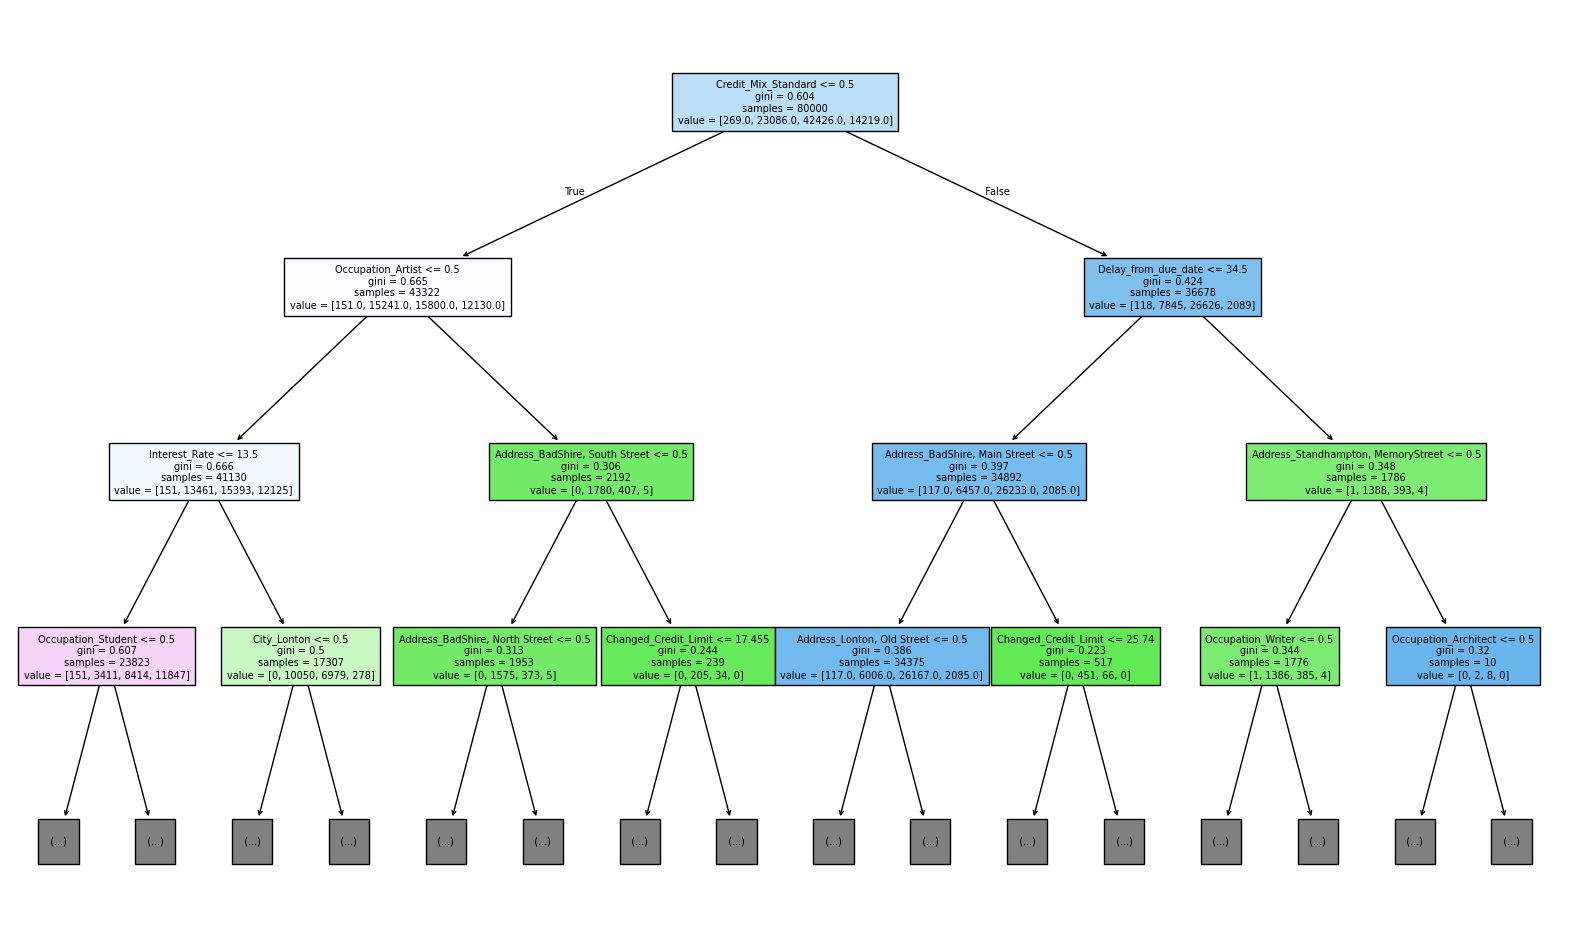

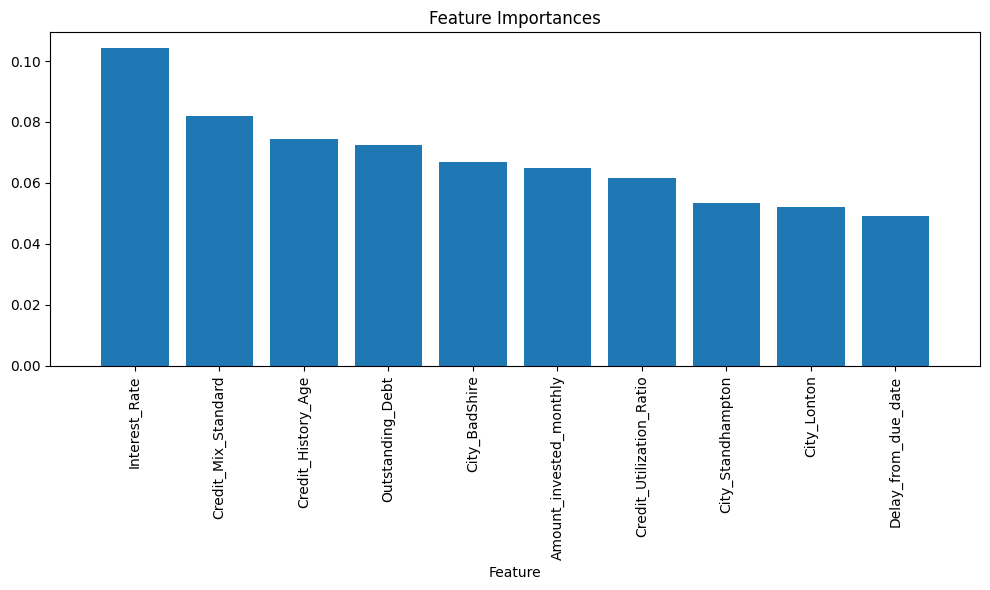

In [18]:
# Visualizing the Decision Tree with a maximum depth of 3
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 12))  # Increased figure size for better readability
plt.title("Decision Tree Visualization (max_depth=3)", fontsize=16)
plot_tree(decision_tree_model, filled=True, feature_names=X.columns, max_depth=3, fontsize=7)
plt.show()

# Feature Importance
importances = decision_tree_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns[indices]
importances = importances[indices]

# Plotting the feature importances (top 10)
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[:10], align='center')
plt.xticks(range(10), features[:10], rotation=90)
plt.xlim([-1, 10])
plt.xlabel("Feature")
plt.tight_layout()
plt.show()
